# StarCat

Flip Tanedo  
Science Hack Day: SF 2017  
  
**Goal**: User inputs an image (perhaps of a cat). This notebook takes the image and identifies a set of stars that form a constellation for that image. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data
from skimage import filters
import skimage.io as io
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.color import *
from random import randint
import os

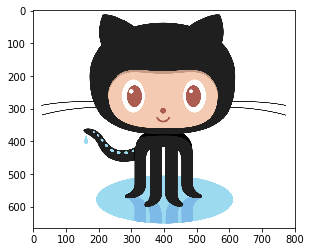

In [2]:
# Input Image
cat_image = io.imread('Octocat.jpg')
plt.imshow(cat_image)
plt.show()

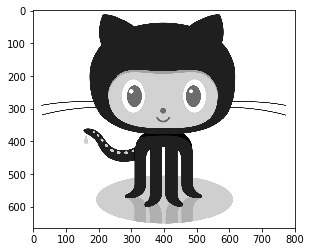

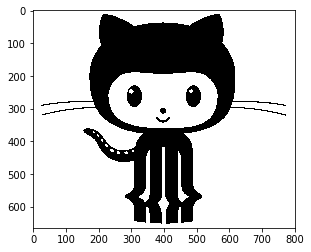

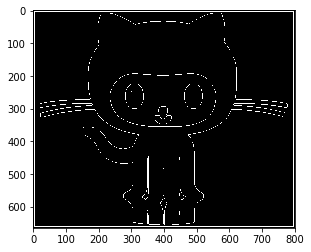

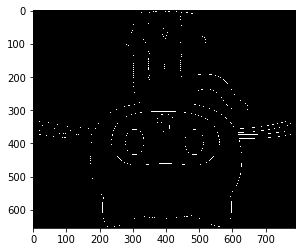

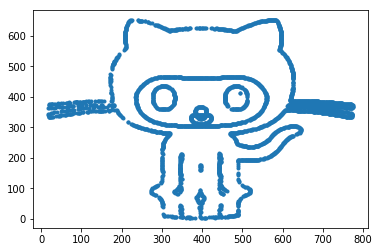

In [11]:
# We need to project down to black & white to use some
# of the scikit-image functions.
graycat = rgb2gray(cat_image)
plt.imshow(graycat, cmap='gray')
plt.show()

# http://www.scipy-lectures.org/packages/scikit-image/#histogram-based-method-otsu-thresholding
thresh = filters.threshold_mean(graycat)
binary = graycat > thresh
plt.imshow(binary, cmap=plt.cm.gray)
plt.show()

# http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html
from scipy import ndimage as ndi
from skimage import feature

edge_cat = feature.canny(binary, sigma=1)
plt.imshow(edge_cat, cmap='gray')
plt.show()

# cleaning for edge pixels, orientation
rotate_edgecat=ndi.rotate(edge_cat, 180, mode='constant')
# plt.imshow(rotate_edgecat, cmap='gray')
# plt.show()

preHeight = np.shape(rotate_edgecat)[0]
preLength = np.shape(rotate_edgecat)[1]

trim_edgecat = rotate_edgecat[5:(preHeight-5),5:(preLength-5)]
plt.imshow(trim_edgecat, cmap='gray')
plt.show()


# Map Cat Image to Separate X and Y arrays
def one_dimensionalize(lineimage):
    """
    Stores points that are in the skeleton.
    Points are a list of pairs.
    i.e. [ [x0,y0], [x1,y1], ... ]
    """
    outline = []
    for ii in range(0,ImageLENGTH-1):
        for jj in range(0,ImageHEIGHT-1):
            if lineimage[jj,ii]:
                outline.append([ii,jj])
    return outline

def outline_x_and_y_lists(lineimage):
    """
    Same as one_dimensionalize,
    but directly gives a list of x-values
    and a list of y-values
    """
    xx = []
    yy = []
    for ii in range(0,ImageLENGTH-1):
        for jj in range(0,ImageHEIGHT-1):
            if lineimage[jj,ii]:
                xx.append(ii)
                yy.append(jj)
    return xx, yy


linexx, lineyy = outline_x_and_y_lists(trim_edgecat)

# plt.imshow(skeleton, cmap=plt.cm.gray)
# use this imshow to plot "right-size up"
plt.plot(np.array(linexx), np.array(lineyy), '.')
# plt.plot(np.array(starx), np.array(stary), 'ro')
plt.show()

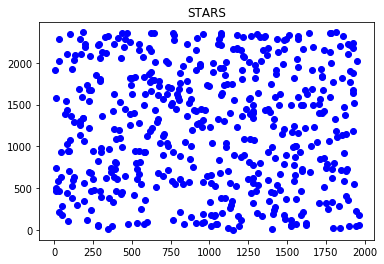

In [8]:
# Make a random star field
# We can replace this with a slice of the actual sky
# Make it MULTIPLIER times larger than the image

MULTIPLIER = 3 
ImageHEIGHT = np.shape(trim_edgecat)[0]
StarHEIGHT = MULTIPLIER*ImageHEIGHT
ImageLENGTH = np.shape(trim_edgecat)[1]
StarLENGTH = MULTIPLIER*ImageLENGTH
NUMSTARS = 500
starx = []
stary = []
for i in range(0,NUMSTARS):
    starx.append(randint(0,StarHEIGHT-1))
    stary.append(randint(0,StarLENGTH-1))
    
# Result: starx and stary are arrays of the star positions
    
plt.plot(np.array(starx), np.array(stary), 'bo')
plt.title("STARS")
plt.show()

In [41]:
# Tools for defining a goodness-of-fit metric

def pixel_distance(i,j,ii,jj):
    return np.sqrt((i-ii)**2 + (j-jj)**2)

def closest_skeleton(ii, jj, skelxx, skelyy):
    """
    Returns point from skelxx, skelyy that is
    closest to the given ii, jj point and the 
    Euclidean distance.
    """
    # Initialize
    closestx = skelxx[0]
    closesty = skelyy[0]
    closestd = np.sqrt(StarHEIGHT**2 + StarLENGTH**2)
    
    for a in range(0,np.size(skelxx)):
        if pixel_distance(ii,jj,skelxx[a],skelyy[a]) < closestd:
            closestx = skelxx[a]
            closesty = skelyy[a]
            closestd = pixel_distance(ii,jj,skelxx[a],skelyy[a])
    return closestx, closesty, closestd

# closest_skeleton(0,0,linexx,lineyy)

def stars_and_closest_skeleton(starxx, staryy, skelxx, skelyy):
    """
    Gives unordered list of star positions, the skeleton position
    that is closest, and the distance between them.
    """
    allpoints=[]
    for a in range(0, np.size(starxx)):
        closex, closey, closed = closest_skeleton(starxx[a], staryy[a], skelxx, skelyy)
        allpoints.append([starxx[a],staryy[a],closex,closey,closed])
    
    return allpoints

# unordered_points = stars_and_closest_skeleton(starx, stary, linexx, lineyy)

def get_best_N_points(NumPoints, unordered_points):
    """
    Returns the NumPoints best fit stars.
    Format: starx, stary, closest_skel_x, closest_skel_y distance
    """
    uop = np.array(unordered_points)
    op = uop[uop[:,4].argsort()]
    return op[0:NumPoints]

# get_best_N_points(10, unordered_points)



def get_best_points(threshold_distance, unordered_points):
    """
    Returns the best fit stars within threshold_distance of the skeleton.
    Format: starx, stary, closest_skel_x, closest_skel_y distance
    """
    uop = np.array(unordered_points)
    op = uop[uop[:,4].argsort()]
    bestpoints = []
    
    for star in op:
        if star[4] < 10:
            bestpoints.append(star)

    return bestpoints

In [14]:
np.array([1,2,3])+3

array([4, 5, 6])

In [36]:
uop = np.array(unordered_points)
op=uop[uop[:,4].argsort()]

for i in op:
    if i[4] < 10:
        print(i)

[ 376.  339.  376.  339.    0.]
[ 192.  349.  192.  348.    1.]
[ 295.  467.  295.  465.    2.]
[ 557.          249.          555.          250.            2.23606798]
[ 435.  459.  435.  463.    4.]
[ 114.          377.          112.          373.            4.47213595]
[ 344.           13.          346.           18.            5.38516481]
[ 516.          415.          511.          412.            5.83095189]
[ 335.          627.          336.          621.            6.08276253]
[ 400.  469.  400.  461.    8.]
